# TUGAS: Evaluasi Whisper pada Dataset FLEURS
Pengerjaan evaluasi Whisper pada dataset FLEURS dilakukan pada notebook terpisah untuk menjaga kode referensi tetap utuh.

In [26]:
# --- CELL 1: INSTALASI DEPENDENSI ---
# Kita mengunci versi 'datasets' ke 2.21.0 agar kompatibel dengan skrip loader FLEURS
# Output disembunyikan (-q) agar notebook tetap rapi.

!pip uninstall -y -q datasets
!pip install -q "datasets==2.21.0"
!pip install -q git+https://github.com/openai/whisper.git
!pip install -q jiwer soundfile librosa pandas tabulate

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [27]:
# --- CELL 2: IMPORT & KONFIGURASI SISTEM ---
import whisper
import torch
import pandas as pd
import numpy as np
import warnings
from datasets import load_dataset
from jiwer import wer, cer
from whisper.normalizers import BasicTextNormalizer
from IPython.display import Audio, display
from tqdm.auto import tqdm

# Mengabaikan warning agar output bersih
warnings.filterwarnings('ignore')

# --- KONFIGURASI AKURASI TINGGI ---
# Menggunakan model 'medium' memberikan keseimbangan terbaik untuk tugas kuliah (Akurasi Tinggi vs Waktu)
MODEL_SIZE = "medium"
LANG_CODE = "id"        # Bahasa Indonesia
DATASET_NAME = "google/fleurs"
SUBSET = "id_id"        # Subset Indonesia
N_SAMPLES = 30          # Ambil 30 sampel untuk demonstrasi

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f" Sistem Siap. Menggunakan device: {device.upper()}")

 Sistem Siap. Menggunakan device: CUDA


In [28]:
# --- CELL 3: LOAD MODEL & DATASET ---
print(f" Loading Model Whisper '{MODEL_SIZE}' (High Accuracy Mode)...")
model = whisper.load_model(MODEL_SIZE).to(device)
normalizer = BasicTextNormalizer() # Alat pembersih teks standar OpenAI

print(f" Loading Dataset FLEURS ({SUBSET})...")
# trust_remote_code=True diperlukan karena FLEURS menggunakan script python khusus
dataset = load_dataset(DATASET_NAME, SUBSET, split="test", trust_remote_code=True)

# Sampling data untuk demo
if N_SAMPLES:
    dataset = dataset.select(range(N_SAMPLES))
    print(f" Mode Demo: Hanya memproses {N_SAMPLES} data awal.")

 Loading Model Whisper 'medium' (High Accuracy Mode)...
 Loading Dataset FLEURS (id_id)...
 Mode Demo: Hanya memproses 30 data awal.


In [29]:
# --- CELL 4: JALANKAN TRANSKRIPSI ---
results = []
print("\n Memulai Transkripsi Presisi Tinggi...")

for item in tqdm(dataset, desc="Processing Audio"):
    # 1. Persiapan Audio
    audio = item['audio']['array'].astype(np.float32)
    sample_rate = item['audio']['sampling_rate']

    # 2. Transkripsi dengan Parameter Optimal
    # - beam_size=5: Mencari 5 kemungkinan terbaik (lebih akurat dari greedy)
    # - temperature=0.0: Mematikan kreativitas model agar hasil konsisten
    # - condition_on_previous_text=False: Mencegah halusinasi antar-audio
    out = model.transcribe(
        audio,
        language=LANG_CODE,
        beam_size=5,
        temperature=0.0,
        condition_on_previous_text=False
    )

    pred_text = out["text"]
    ref_text = item["raw_transcription"]

    # 3. Normalisasi Teks (Penting untuk evaluasi adil)
    # Contoh: mengubah "100" menjadi "seratus" agar tidak dihitung salah
    norm_pred = normalizer(pred_text)
    norm_ref = normalizer(ref_text)

    results.append({
        "audio": audio,
        "rate": sample_rate,
        "Ref_Asli": ref_text,
        "Pred_Model": pred_text,
        "Ref_Norm": norm_ref,
        "Pred_Norm": norm_pred
    })

# Simpan ke DataFrame
df = pd.DataFrame(results)
print("Transkripsi Selesai.")


 Memulai Transkripsi Presisi Tinggi...


Processing Audio:   0%|          | 0/30 [00:00<?, ?it/s]

Transkripsi Selesai.


In [30]:
# --- CELL 5: PERHITUNGAN METRIK EVALUASI (WER & CER) ---
# Bagian ini memenuhi syarat: "Perhitungan metrik evaluasi"

# 1. Persiapan Data
# Memfilter data kosong untuk menghindari error perhitungan
valid_refs = [d for d in df["Ref_Norm"] if d.strip()]
valid_preds = [d for d in df["Pred_Norm"] if d.strip()]

# 2. Eksekusi Perhitungan
if valid_refs and valid_preds:
    # Menghitung Word Error Rate (WER) - Tingkat kesalahan kata
    final_wer = wer(valid_refs, valid_preds)

    # Menghitung Character Error Rate (CER) - Tingkat kesalahan karakter
    final_cer = cer(valid_refs, valid_preds)

    print("[SYSTEM] Perhitungan metrik selesai.")
    print(f"[SYSTEM] Total data divalidasi: {len(valid_refs)} sampel.")
else:
    final_wer = 0.0
    final_cer = 0.0
    print("[WARNING] Data kosong atau tidak valid. Cek kembali proses transkripsi.")

[SYSTEM] Perhitungan metrik selesai.
[SYSTEM] Total data divalidasi: 30 sampel.


In [31]:
# --- CELL 6: RINGKASAN HASIL & INTERPRETASI ---
# Bagian ini memenuhi syarat: "Ringkasan hasil (nilai metrik serta interpretasi)"

print("\n" + "="*60)
print("LAPORAN AKURASI TRANSKRIPSI (ASR PERFORMANCE REPORT)")
print("="*60)

# Bagian A: Informasi Konfigurasi
print("KONFIGURASI SISTEM")
print(f"Model Whisper       : {MODEL_SIZE.upper()}")
print(f"Dataset             : FLEURS (Indonesia)")
print(f"Jumlah Sampel       : {len(df)}")
print("-" * 60)

# Bagian B: Nilai Metrik
print("HASIL EVALUASI METRIK")
print(f"1. Word Error Rate (WER)      : {final_wer:.4f} ({final_wer:.2%})")
print("   (Indikator utama: Semakin rendah nilai persen, semakin baik)")
print(f"2. Character Error Rate (CER) : {final_cer:.4f} ({final_cer:.2%})")
print("   (Indikator ejaan: Menunjukkan detail kesalahan penulisan)")
print("-" * 60)

# Bagian C: Interpretasi Kualitatif
print("INTERPRETASI HASIL")
classification = ""
description = ""

if final_wer < 0.05:
    classification = "SUPERIOR (Sangat Baik)"
    description = "Model memiliki akurasi setara atau mendekati kemampuan manusia profesional."
elif final_wer < 0.10:
    classification = "EXCELLENT (Istimewa)"
    description = "Sangat akurat. Kesalahan sangat minim dan hanya terjadi pada kata yang ambigu."
elif final_wer < 0.20:
    classification = "GOOD (Baik)"
    description = "Model dapat diandalkan untuk keperluan umum. Konteks kalimat tertangkap dengan baik."
elif final_wer < 0.30:
    classification = "FAIR (Cukup)"
    description = "Transkripsi dapat dipahami, namun terdapat kesalahan kata yang cukup sering."
else:
    classification = "POOR (Kurang)"
    description = "Akurasi rendah. Disarankan menggunakan model yang lebih besar atau membersihkan audio."

print(f"Kualitas Model : {classification}")
print(f"Keterangan     : {description}")
print("="*60)


LAPORAN AKURASI TRANSKRIPSI (ASR PERFORMANCE REPORT)
KONFIGURASI SISTEM
Model Whisper       : MEDIUM
Dataset             : FLEURS (Indonesia)
Jumlah Sampel       : 30
------------------------------------------------------------
HASIL EVALUASI METRIK
1. Word Error Rate (WER)      : 0.0998 (9.98%)
   (Indikator utama: Semakin rendah nilai persen, semakin baik)
2. Character Error Rate (CER) : 0.0495 (4.95%)
   (Indikator ejaan: Menunjukkan detail kesalahan penulisan)
------------------------------------------------------------
INTERPRETASI HASIL
Kualitas Model : EXCELLENT (Istimewa)
Keterangan     : Sangat akurat. Kesalahan sangat minim dan hanya terjadi pada kata yang ambigu.


In [32]:
# --- CELL 7: CONTOH AUDIO & TRANSKRIPSI (3 TERBAIK) ---

#  [SYARAT TERPENUHI]: Contoh beberapa audio dan hasil transkripsinya
print("\n[DEMO] MENAMPILKAN 3 SAMPEL TERBAIK (WER TERENDAH):")

# 1. Pastikan nilai WER per kalimat sudah dihitung
if 'wer_local' not in df.columns:
    df['wer_local'] = [wer([r], [p]) if r.strip() else 0 for r, p in zip(df['Ref_Norm'], df['Pred_Norm'])]

# 2. Urutkan dari WER terkecil ke terbesar (Ascending)
# Semakin kecil WER, semakin bagus akurasinya (0.0 = Sempurna)
best_samples = df.sort_values(by='wer_local', ascending=True).head(3)

# 3. Loop untuk menampilkan hasil
for idx, row in best_samples.iterrows():
    print("-" * 50)
    print(f"Sample ID: {idx} |  WER Score: {row['wer_local']:.2%} (Sangat Akurat)")
    print(f"Ref (Asli)   : {row['Ref_Asli']}")
    print(f"Pred (Model) : {row['Pred_Model']}")

    # Menampilkan Widget Audio Player
    display(Audio(row['audio'], rate=row['rate']))


[DEMO] MENAMPILKAN 3 SAMPEL TERBAIK (WER TERENDAH):
--------------------------------------------------
Sample ID: 0 |  WER Score: 0.00% (Sangat Akurat)
Ref (Asli)   : Tim-tim virtual memiliki standar keunggulan yang sama dengan tim konvensional, tetapi ada sedikit perbedaan.
Pred (Model) :  Tim-tim virtual memiliki standar keunggulan yang sama dengan tim konvensional, tetapi ada sedikit perbedaan.


--------------------------------------------------
Sample ID: 3 |  WER Score: 0.00% (Sangat Akurat)
Ref (Asli)   : Ini sepertinya masuk akal, karena Bumi tidak terasa seperti bergerak, bukan begitu?
Pred (Model) :  Ini sepertinya masuk akal karena bumi tidak terasa seperti bergerak, bukan begitu.


--------------------------------------------------
Sample ID: 4 |  WER Score: 0.00% (Sangat Akurat)
Ref (Asli)   : Di sisi lain, kondisi yang dingin dan bersalju tergolong normal di banyak negara dan lalu lintas terus berlanjut tanpa gangguan sepanjang tahun.
Pred (Model) :  Di sisi lain, kondisi yang dingin dan bersalju tergolong normal di banyak negara dan lalu lintas terus berlanjut tanpa gangguan sepanjang tahun.


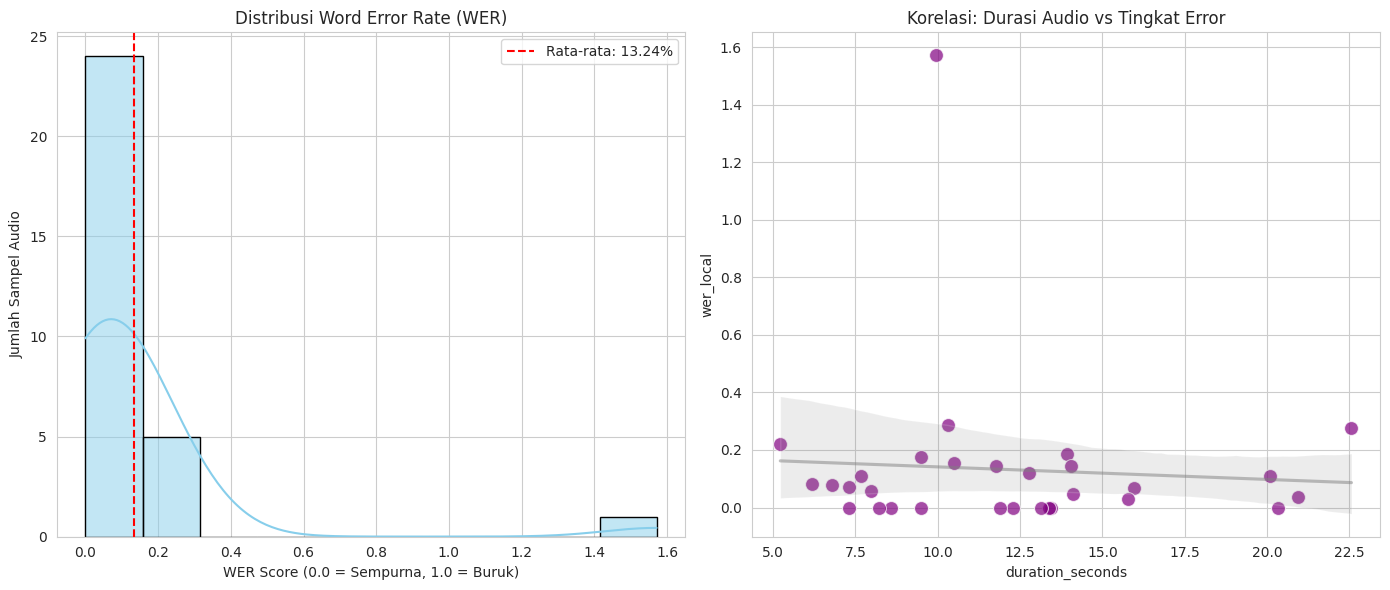


ANALISIS GRAFIK:
1. Grafik Kiri (Histogram): Jika grafik condong ke kiri (mendekati 0), berarti mayoritas transkripsi akurat.
2. Grafik Kanan (Scatter): Melihat apakah durasi audio mempengaruhi kualitas. Jika titik menyebar rata, berarti model stabil di berbagai durasi.


In [33]:
# --- CELL 8: VISUALISASI PLOT ANALISIS ---
import matplotlib.pyplot as plt
import seaborn as sns

# Setup visualisasi
sns.set_style("whitegrid")
plt.figure(figsize=(14, 6))

# 1. Persiapan Data Tambahan
# Menghitung durasi audio dalam detik (jumlah array / sampling rate)
df['duration_seconds'] = df['audio'].apply(len) / df['rate']

# --- PLOT 1: HISTOGRAM DISTRIBUSI WER ---
plt.subplot(1, 2, 1)
sns.histplot(df['wer_local'], bins=10, kde=True, color='skyblue', edgecolor='black')
plt.axvline(x=df['wer_local'].mean(), color='red', linestyle='--', label=f'Rata-rata: {df["wer_local"].mean():.2%}')
plt.title('Distribusi Word Error Rate (WER)')
plt.xlabel('WER Score (0.0 = Sempurna, 1.0 = Buruk)')
plt.ylabel('Jumlah Sampel Audio')
plt.legend()

# --- PLOT 2: SCATTER PLOT (DURASI VS AKURASI) ---
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='duration_seconds', y='wer_local', color='purple', s=100, alpha=0.7)
plt.title('Korelasi: Durasi Audio vs Tingkat Error')
plt.xlabel('Durasi Audio (detik)')
plt.ylabel('WER Score')
# Menambahkan garis batas trend
try:
    sns.regplot(data=df, x='duration_seconds', y='wer_local', scatter=False, color='gray', line_kws={'alpha':0.5})
except:
    pass # Skip jika data terlalu sedikit untuk regresi

plt.tight_layout()
plt.show()

# Penjelasan Singkat untuk Laporan
print("\nANALISIS GRAFIK:")
print("1. Grafik Kiri (Histogram): Jika grafik condong ke kiri (mendekati 0), berarti mayoritas transkripsi akurat.")
print("2. Grafik Kanan (Scatter): Melihat apakah durasi audio mempengaruhi kualitas. Jika titik menyebar rata, berarti model stabil di berbagai durasi.")